# 🩺 Breast Cancer Stage Prediction (SEER / AJCC 6th Edition)

This notebook builds machine learning models to predict **AJCC 6th edition stage groups** for breast cancer:
**IIA, IIB, IIIA, IIIB, IIIC**.

The workflow is designed to be reproducible and to highlight both:
- **Overall predictive performance** (accuracy, weighted-F1)
- **Minority-class sensitivity** (false negatives per class), especially for rare stages (e.g., IIIB)

> Important note: Some staging-related variables (e.g., *T Stage, N Stage, A Stage*) can act as “shortcut” features and lead to overly optimistic results.  
> This notebook removes those variables to evaluate models on more general clinical/demographic predictors.


## Notebook Structure
1. Load & clean dataset  
2. Define target and encode labels  
3. Build feature set and remove shortcut staging variables (one step)  
4. Train/test split (stratified)  
5. Baseline models: Logistic Regression & Random Forest (with preprocessing pipeline)  
6. Evaluation: classification report + confusion matrices + false negatives per class  
7. “Safety attempt”: threshold tuning to reduce false negatives for rare stage (IIIB)


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/data.csv")

df.head()



,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive
2,67,White,Married (including common law),NaN,T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead
3,46,White,Divorced,NaN,T1,N1,IIA,Moderately differentiated; Grade II,Regional,19,Positive,Positive,26,1,2,Dead
4,63,White,Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,35,Positive,Positive,21,5,3,Dead


In [2]:

print("Rows, Columns:", df.shape)


print("\nColumns:\n", df.columns)

# Preview the first 5 rows 
df.head()


Rows, Columns: (4024, 16)

Columns:
 Index(['Age', 'Race ', 'Marital Status', 'Unnamed: 3', 'T Stage ', 'N Stage',
       '6th Stage', 'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')


,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive
2,67,White,Married (including common law),NaN,T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead
3,46,White,Divorced,NaN,T1,N1,IIA,Moderately differentiated; Grade II,Regional,19,Positive,Positive,26,1,2,Dead
4,63,White,Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,35,Positive,Positive,21,5,3,Dead


In [3]:
# Check what unique stage values appear in ‘6th Stage’
df["6th Stage"].value_counts(dropna=False)


6th Stage
IIA     1305
IIB     1130
IIIA    1050
IIIC     472
IIIB      67
Name: count, dtype: int64

In [4]:
# Check for missing values in the entire dataset
df.isnull().sum()


Age                          0
Race                         0
Marital Status               0
Unnamed: 3                4024
T Stage                      0
N Stage                      0
6th Stage                    0
Grade                        0
A Stage                      0
Tumor Size                   0
Estrogen Status              0
Progesterone Status          0
Regional Node Examined       0
Reginol Node Positive        0
Survival Months              0
Status                       0
dtype: int64

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# CLean dataframe
df = df.drop(columns=["Unnamed: 3"], errors="ignore")
df.columns = df.columns.str.strip()

print("Rows, Columns:", df.shape)
print("Columns:\n", df.columns)

# Define target and features 
y_raw = df["6th Stage"].astype(str).str.strip()   
X = df.drop(columns=["6th Stage"])

print("X shape:", X.shape)
print("y distribution:\n", y_raw.value_counts())

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

print("\nStage Labels (class order used for encoding):")
for i, cls in enumerate(label_encoder.classes_):
    print(f"{i} -> {cls}")


Rows, Columns: (4024, 15)
Columns:
 Index(['Age', 'Race', 'Marital Status', 'T Stage', 'N Stage', '6th Stage',
       'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')
X shape: (4024, 14)
y distribution:
 6th Stage
IIA     1305
IIB     1130
IIIA    1050
IIIC     472
IIIB      67
Name: count, dtype: int64

Stage Labels (class order used for encoding):
0 -> IIA
1 -> IIB
2 -> IIIA
3 -> IIIB
4 -> IIIC


In [6]:
# Identify and drop data leakage columns
leakage_cols = ["Survival Months", "Status"]
df = df.drop(columns=leakage_cols, errors="ignore")

print("After dropping leakage columns:", df.shape)
print("Remaining columns:\n", df.columns)


After dropping leakage columns: (4024, 13)
Remaining columns:
 Index(['Age', 'Race', 'Marital Status', 'T Stage', 'N Stage', '6th Stage',
       'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive'],
      dtype='object')


In [7]:
import numpy as np

print("Missing values per column:")
print(df.isnull().sum())

print("\nUnique stages (encoded):", np.unique(y))


Missing values per column:
Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
dtype: int64

Unique stages (encoded): [0 1 2 3 4]


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Train shapes: (3219, 14) (3219,)
Test shapes: (805, 14) (805,)


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Identify column types
cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(exclude=["object"]).columns

print("Categorical columns:", list(cat_cols))
print("Numerical columns:", list(num_cols))

# Preprocessing: one-hot encode categoricals, scale numericals
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)


Categorical columns: ['Race', 'Marital Status', 'T Stage', 'N Stage', 'Grade', 'A Stage', 'Estrogen Status', 'Progesterone Status', 'Status']
Numerical columns: ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']



--- Logistic Regression Results ---
Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       261
           1       1.00      1.00      1.00       226
           2       1.00      1.00      1.00       210
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        95

    accuracy                           1.00       805
   macro avg       1.00      1.00      1.00       805
weighted avg       1.00      1.00      1.00       805



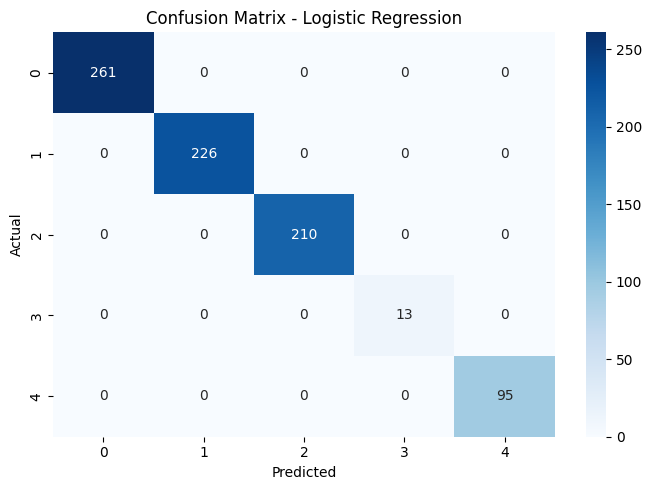

In [10]:
# LOGISTIC REGRESSION PIPELINE 


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Build the full pipeline: preprocessing + logistic regression
logreg_model = Pipeline(steps=[
    ("preprocess", preprocess),  
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

# Train
logreg_model.fit(X_train, y_train)

# Predict
y_pred = logreg_model.predict(X_test)

# Evaluate
print("\n--- Logistic Regression Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import pandas as pd

# Use the pipeline you actually trained in your notebook
pipe = logreg_model

pre = pipe.named_steps["preprocess"]
clf = pipe.named_steps["clf"]

# After fit(), ColumnTransformer can provide expanded feature names
feature_names = pre.get_feature_names_out()

# Coefficients from the trained logistic regression model
coefs = clf.coef_

# Aggregate “importance” across classes 
importance = np.linalg.norm(coefs, axis=0)

imp_df = (pd.DataFrame({"feature": feature_names, "importance": importance})
          .sort_values("importance", ascending=False))

imp_df.head(30)


,feature,importance
11,cat__T Stage_T4,5.879421
14,cat__N Stage_N3,5.005841
13,cat__N Stage_N2,4.963604
9,cat__T Stage_T2,4.810505
12,cat__N Stage_N1,4.383082
10,cat__T Stage_T3,3.959447
8,cat__T Stage_T1,3.957770
30,num__Reginol Node Positive,1.810017
28,num__Tumor Size,1.792615
19,cat__A Stage_Distant,0.962668


In [12]:
from sklearn.model_selection import train_test_split

# Drop shortcut staging cols
shortcut_cols = ["T Stage", "N Stage", "A Stage"]
shortcut_cols = [c for c in shortcut_cols if c in X.columns]
X2 = X.drop(columns=shortcut_cols)

# Re-split using the same y as before
X2_train, X2_test, y_train, y_test = train_test_split(
    X2, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Dropped:", shortcut_cols)
print("Train shapes:", X2_train.shape, y_train.shape)
print("Test shapes:", X2_test.shape, y_test.shape)


Dropped: ['T Stage', 'N Stage', 'A Stage']
Train shapes: (3219, 11) (3219,)
Test shapes: (805, 11) (805,)


In [13]:

# PREPROCESSING SETUP

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Ensure clean column names (important if you had trailing spaces earlier)
X2_train = X2_train.copy()
X2_test = X2_test.copy()
X2_train.columns = X2_train.columns.str.strip()
X2_test.columns = X2_test.columns.str.strip()

# Identify categorical vs numerical columns
cat_cols2 = X2_train.select_dtypes(include=["object"]).columns
num_cols2 = X2_train.select_dtypes(exclude=["object"]).columns

print("Categorical columns:", list(cat_cols2))
print("Numerical columns:", list(num_cols2))

# Preprocessing: one-hot encode categoricals, scale numericals
preprocess2 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols2),
        ("num", StandardScaler(), num_cols2),
    ],
    remainder="drop"
)


Categorical columns: ['Race', 'Marital Status', 'Grade', 'Estrogen Status', 'Progesterone Status', 'Status']
Numerical columns: ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']


Accuracy: 0.7565217391304347

Classification report:

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       261
           1       0.82      0.74      0.78       226
           2       0.76      0.52      0.62       210
           3       0.05      0.38      0.09        13
           4       0.86      0.94      0.90        95

    accuracy                           0.76       805
   macro avg       0.68      0.70      0.66       805
weighted avg       0.83      0.76      0.78       805



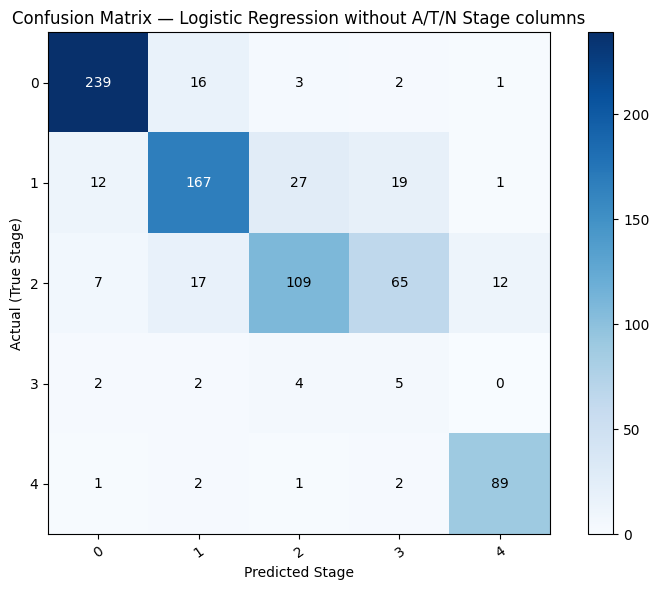

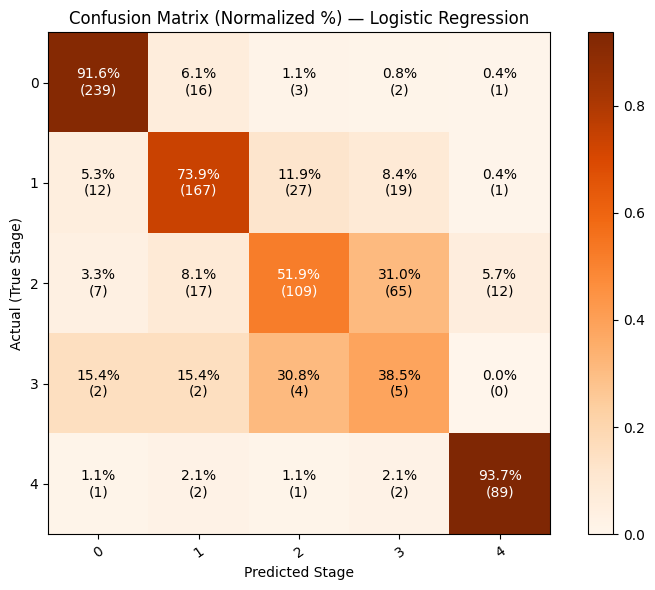

In [14]:
# Logistic Regression Pipeline (without A/T/N Stage columns) — no LabelEncoder required

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt


# Build + train the pipeline

model2 = Pipeline(steps=[
    ("preprocess", preprocess2),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

model2.fit(X2_train, y_train)
y_pred2 = model2.predict(X2_test)




labels = np.unique(np.concatenate([y_test, y_pred2]))
class_names = [str(l) for l in labels]  # uses the label values as names


# Metrics

print("Accuracy:", accuracy_score(y_test, y_pred2))
print("\nClassification report:\n")
print(classification_report(
    y_test, y_pred2,
    labels=labels,
    target_names=class_names,
    zero_division=0
))


# Confusion matrix plotting

def plot_cm(y_true, y_pred, labels, class_names, title, cmap="Blues", normalize=False):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    cm_display = cm.astype(float)
    if normalize:
        row_sums = cm_display.sum(axis=1, keepdims=True)
        cm_display = np.divide(cm_display, row_sums, where=row_sums != 0)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm_display, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        title=title,
        ylabel="Actual (True Stage)",
        xlabel="Predicted Stage",
    )
    plt.setp(ax.get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")

    thresh = cm_display.max() / 2.0 if cm_display.size else 0
    for i in range(cm_display.shape[0]):
        for j in range(cm_display.shape[1]):
            if normalize:
                text = f"{cm_display[i, j]*100:.1f}%\n({cm[i, j]})"
            else:
                text = str(cm[i, j])

            ax.text(
                j, i, text,
                ha="center", va="center",
                color="white" if cm_display[i, j] > thresh else "black",
                fontsize=10
            )

    ax.set_ylim(len(class_names) - 0.5, -0.5)
    plt.tight_layout()
    plt.show()

# Plot both versions
plot_cm(y_test, y_pred2, labels, class_names,
        "Confusion Matrix — Logistic Regression without A/T/N Stage columns", cmap="Blues", normalize=False)

plot_cm(y_test, y_pred2, labels, class_names,
        "Confusion Matrix (Normalized %) — Logistic Regression", cmap="Oranges", normalize=True)


Random Forest training complete ✅
Accuracy: 0.9478260869565217

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       261
           1       0.96      0.93      0.95       226
           2       0.88      0.98      0.93       210
           3       0.00      0.00      0.00        13
           4       0.96      0.95      0.95        95

    accuracy                           0.95       805
   macro avg       0.76      0.77      0.76       805
weighted avg       0.93      0.95      0.94       805



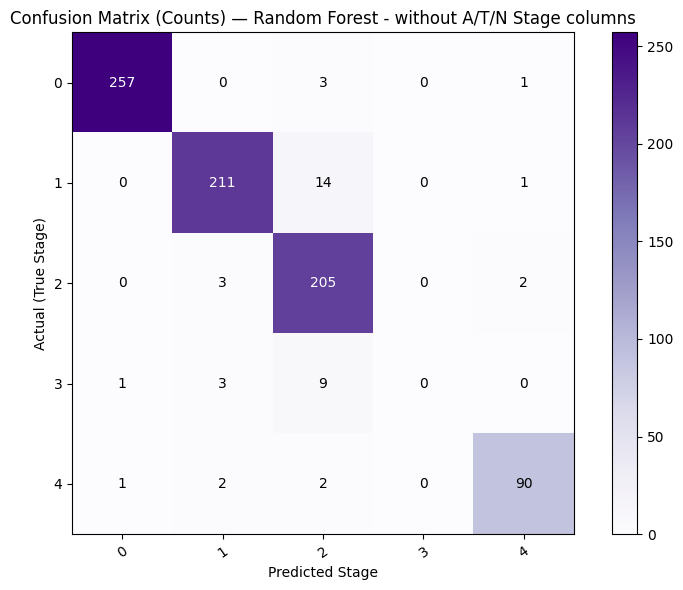

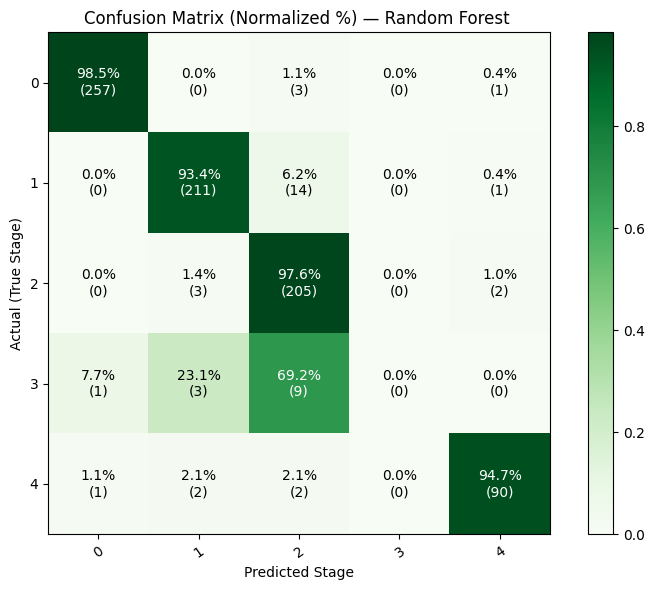

In [15]:
# Random Forest (without A/T/N Stage columns) 

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt


# Confusion matrix plotting

def plot_cm(y_true, y_pred, labels, class_names, title, cmap="Blues", normalize=False):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    cm_display = cm.astype(float)
    if normalize:
        row_sums = cm_display.sum(axis=1, keepdims=True)
        cm_display = np.divide(cm_display, row_sums, where=row_sums != 0)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm_display, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        title=title,
        ylabel="Actual (True Stage)",
        xlabel="Predicted Stage",
    )
    plt.setp(ax.get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")

    thresh = cm_display.max() / 2.0 if cm_display.size else 0
    for i in range(cm_display.shape[0]):
        for j in range(cm_display.shape[1]):
            if normalize:
                text = f"{cm_display[i, j]*100:.1f}%\n({cm[i, j]})"
            else:
                text = str(cm[i, j])

            ax.text(
                j, i, text,
                ha="center", va="center",
                color="white" if cm_display[i, j] > thresh else "black",
                fontsize=10
            )

    ax.set_ylim(len(class_names) - 0.5, -0.5)
    plt.tight_layout()
    plt.show()


# Build + train the pipeline

rf_model = Pipeline(steps=[
    ("preprocess", preprocess2),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf_model.fit(X2_train, y_train)
print("Random Forest training complete ✅")

# Predict + evaluate

y_pred_rf = rf_model.predict(X2_test)

labels = np.unique(np.concatenate([y_test, y_pred_rf]))
class_names = [str(l) for l in labels]

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification report:\n")
print(classification_report(
    y_test, y_pred_rf,
    labels=labels,
    target_names=class_names,
    zero_division=0
))


# Confusion matrices

plot_cm(y_test, y_pred_rf, labels, class_names,
        "Confusion Matrix (Counts) — Random Forest - without A/T/N Stage columns", cmap="Purples", normalize=False)

plot_cm(y_test, y_pred_rf, labels, class_names,
        "Confusion Matrix (Normalized %) — Random Forest ", cmap="Greens", normalize=True)


                   feature  importance_mean  importance_std
8    Reginol Node Positive         0.381459        0.011393
4               Tumor Size         0.265910        0.009387
5          Estrogen Status         0.000809        0.000394
10                  Status        -0.000348        0.000552
1                     Race        -0.000906        0.000570
6      Progesterone Status        -0.000966        0.000612
0                      Age        -0.001294        0.000897
3                    Grade        -0.001381        0.000731
2           Marital Status        -0.001439        0.000726
9          Survival Months        -0.001558        0.000703
7   Regional Node Examined        -0.002166        0.000557


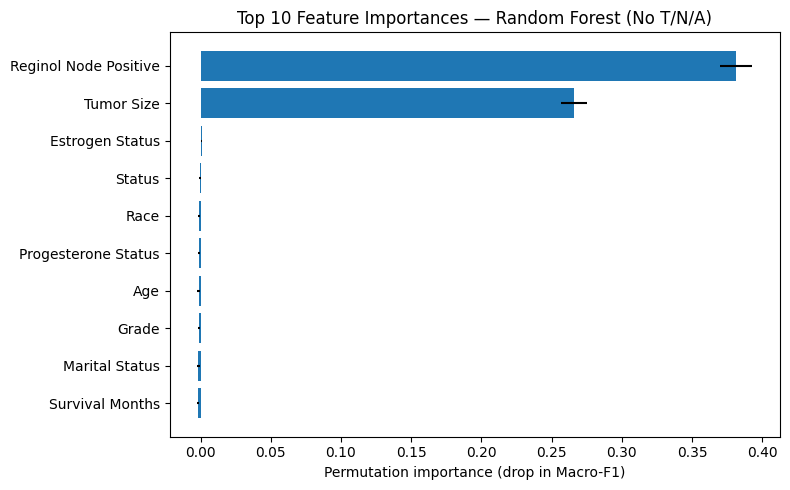

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_model, X2_test, y_test,
    scoring="f1_macro",
    n_repeats=15,
    random_state=42,
    n_jobs=-1
)

imp = pd.DataFrame({
    "feature": X2_test.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

print(imp)

# Plot top 10 
top = imp.head(10).sort_values("importance_mean")
plt.figure(figsize=(8, 5))
plt.barh(top["feature"], top["importance_mean"], xerr=top["importance_std"])
plt.xlabel("Permutation importance (drop in Macro-F1)")
plt.title("Top 10 Feature Importances — Random Forest (No T/N/A)")
plt.tight_layout()
plt.show()
